In [103]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

hdir = '/home/workspace/'

# df = pd.read_csv(hdir + 'mm_bm_chip_organoids/mm_aggregated_metrics.csv', header=1)
df1 = pd.read_csv(os.path.join(hdir, "mm_bm_chip_organoids/aggregated_metrics/EXP-01244_aggregated_metrics.csv"), header=None).T
df2 = pd.read_csv(os.path.join(hdir, "mm_bm_chip_organoids/aggregated_metrics/EXP-01440_aggregated_metrics.csv"), header=None).T.iloc[1:,:]

df = pd.concat([df1, df2], ignore_index=True)
df.columns = df.iloc[0]
df = df.drop(0)
df = df.reset_index(drop=True)

sample_type = {
    name: (
        'bm_starter' if 'BMC' in name else
        'msc_starter' if 'CELL' in name else
        'organoid'
    ) for name in df.iloc[:,0]
}

df['Sample Type'] = sample_type.values()

df['Cells'] = df['Cells'].str.replace(',', '').astype(int)
df['Median UMI counts per cell'] = df['Median UMI counts per cell'].str.replace(',', '').astype(int)

df.to_csv('mm_aggregated_metrics.csv')

In [66]:
df.head(5)

,Metric Name,EXP #,Cells,Confidently mapped reads in cells,Estimated UMIs from genomic DNA,Estimated UMIs from genomic DNA per unspliced probe,Mean reads per cell,Median UMI counts per cell,Median genes per cell,Number of reads from cells called from this sample,Reads confidently mapped to filtered probe set,Reads confidently mapped to probe set,Reads half-mapped to probe set,Reads mapped to probe set,Reads split-mapped to probe set,Total genes detected,Cells detected in other samples,Cells detected in this sample,Sample Type
0,BMC07965-007_1,EXP-01244,651,63.28%,1.71%,1,"3,822",943,661,"2,488,392",88.47%,97.68%,0.26%,99.08%,1.13%,"12,816","48,784 (98.68%)",651 (1.32%),bm_starter
1,BMC07965-007_2,EXP-01244,551,46.32%,2.53%,1,"3,317",846,524,"1,827,755",85.36%,97.95%,0.21%,99.08%,0.91%,"12,349","48,884 (98.89%)",551 (1.11%),bm_starter
2,BMC07965-007_3,EXP-01244,1205,56.28%,1.19%,1,"3,246",853,603,"3,911,607",89.68%,97.43%,0.29%,99.04%,1.33%,"13,202","48,230 (97.56%)","1,205 (2.44%)",bm_starter
3,CELL00911,EXP-01244,10158,95.28%,0.01%,1,"48,655","10,596","3,602","494,233,842",96.90%,98.50%,0.22%,98.99%,0.26%,"15,186","39,277 (79.45%)","10,158 (20.55%)",msc_starter
4,OR00001_1,EXP-01244,2616,75.39%,0.13%,1,"14,468","4,004","1,885","37,847,876",95.80%,98.03%,0.24%,99.14%,0.87%,"14,430","46,819 (94.71%)","2,616 (5.29%)",organoid


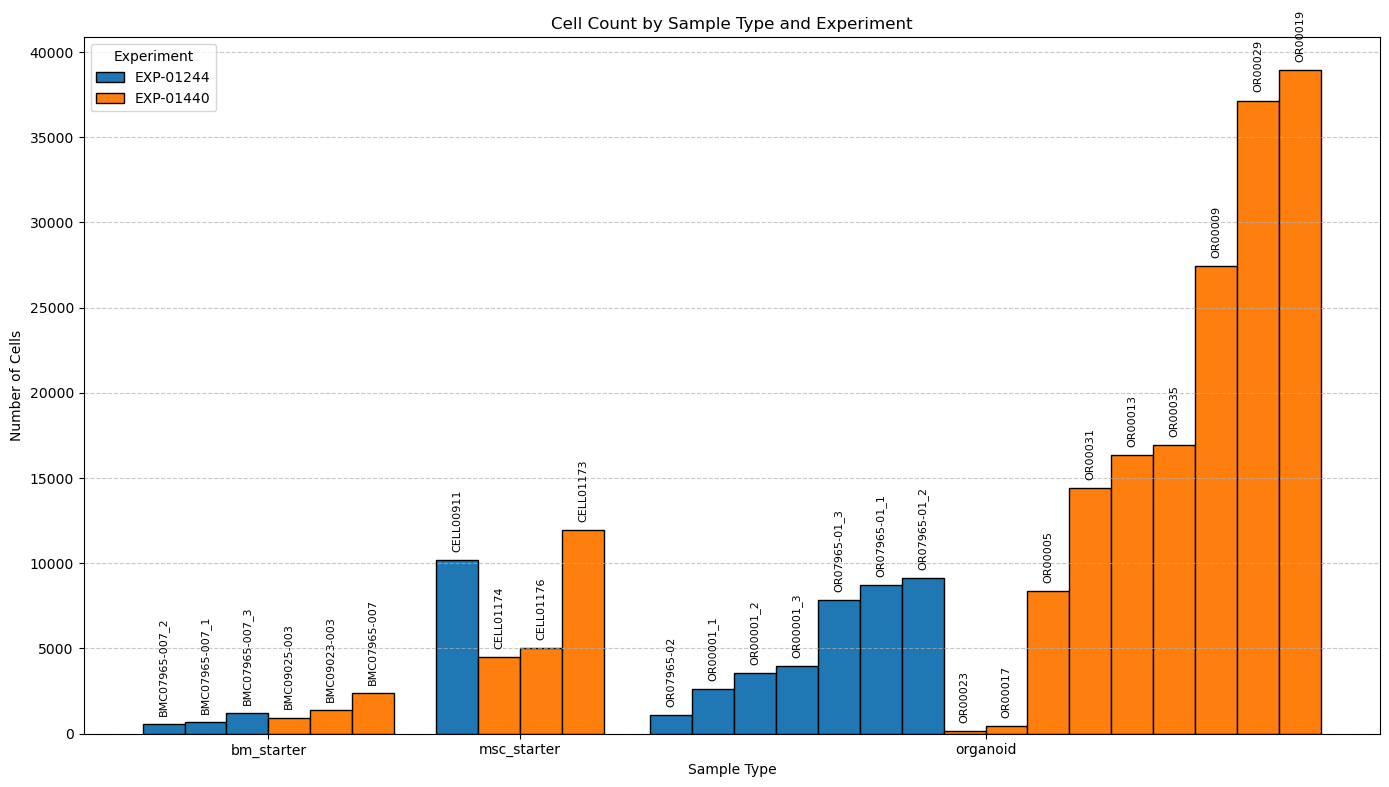

In [100]:
# Group the data by Sample Type
sample_types = sorted(df['Sample Type'].unique())
experiments = sorted(df['EXP #'].unique())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Set width of bars and positions of groups
bar_width = 0.8 / len(df.groupby(['Sample Type', 'EXP #']).size())

group_positions = np.array([0, 0.8, 2.28])

# Create a mapping of experiments to colors
exp_colors = {exp: plt.cm.tab10(i) for i, exp in enumerate(experiments)}

# Create a list to store bar information
bars_info = []

# Process each row of the dataframe
for idx, row in df.iterrows():
    # Get sample information
    sample_type = row['Sample Type']
    sample_name = row['Metric Name']
    experiment = row['EXP #']
    cell_count = row['Cells']
    
    # Get the actual position value from group_positions, not just the index
    group_idx = sample_types.index(sample_type)
    group_pos = group_positions[group_idx]  # This is the key change
    
    # Store information for plotting later
    bars_info.append({
        'sample_type': sample_type,
        'group_idx': group_idx,
        'group_pos': group_pos,  # Store the actual position
        'sample_name': sample_name,
        'experiment': experiment,
        'cell_count': cell_count
    })
    
# Sort bars within each group based on experiment
bars_info.sort(key=lambda x: (x['group_idx'], x['experiment'], x['cell_count']))

# Calculate positions for each bar
bar_counts = {st: 0 for st in sample_types}
for bar in bars_info:
    sample_type = bar['sample_type']
    # Calculate position within the group
    position_in_group = bar_counts[sample_type]
    total_in_group = sum(1 for b in bars_info if b['sample_type'] == sample_type)
    
    # Calculate x position
    bar['x_pos'] = bar['group_pos'] + (position_in_group - total_in_group/2 + 0.5) * bar_width
    
    # Increment counter
    bar_counts[sample_type] += 1

# Create legend handles
legend_handles = {exp: None for exp in experiments}

# Plot all bars
for bar in bars_info:
    x_pos = bar['x_pos']
    height = bar['cell_count']
    color = exp_colors[bar['experiment']]
    
    # Plot the bar
    bar_obj = ax.bar(x_pos, height, width=bar_width,
                    color=color, edgecolor='black', linewidth=1)
    
    # Update legend handle if needed
    if legend_handles[bar['experiment']] is None:
        legend_handles[bar['experiment']] = bar_obj[0]
    
    # Add sample name annotation
    ax.text(x_pos, height+500, bar['sample_name'],
            ha='center', va='bottom', rotation=90, fontsize=8)

# Set the x-axis ticks and labels
ax.set_xticks(group_positions)
ax.set_xticklabels(sample_types)

# Add labels and title
plt.xlabel('Sample Type')
plt.ylabel('Number of Cells')
plt.title('Cell Count by Sample Type and Experiment')

# Add a legend for the experiments
plt.legend(legend_handles.values(), legend_handles.keys(),
           title='Experiment', loc='upper left')

# Add grid for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

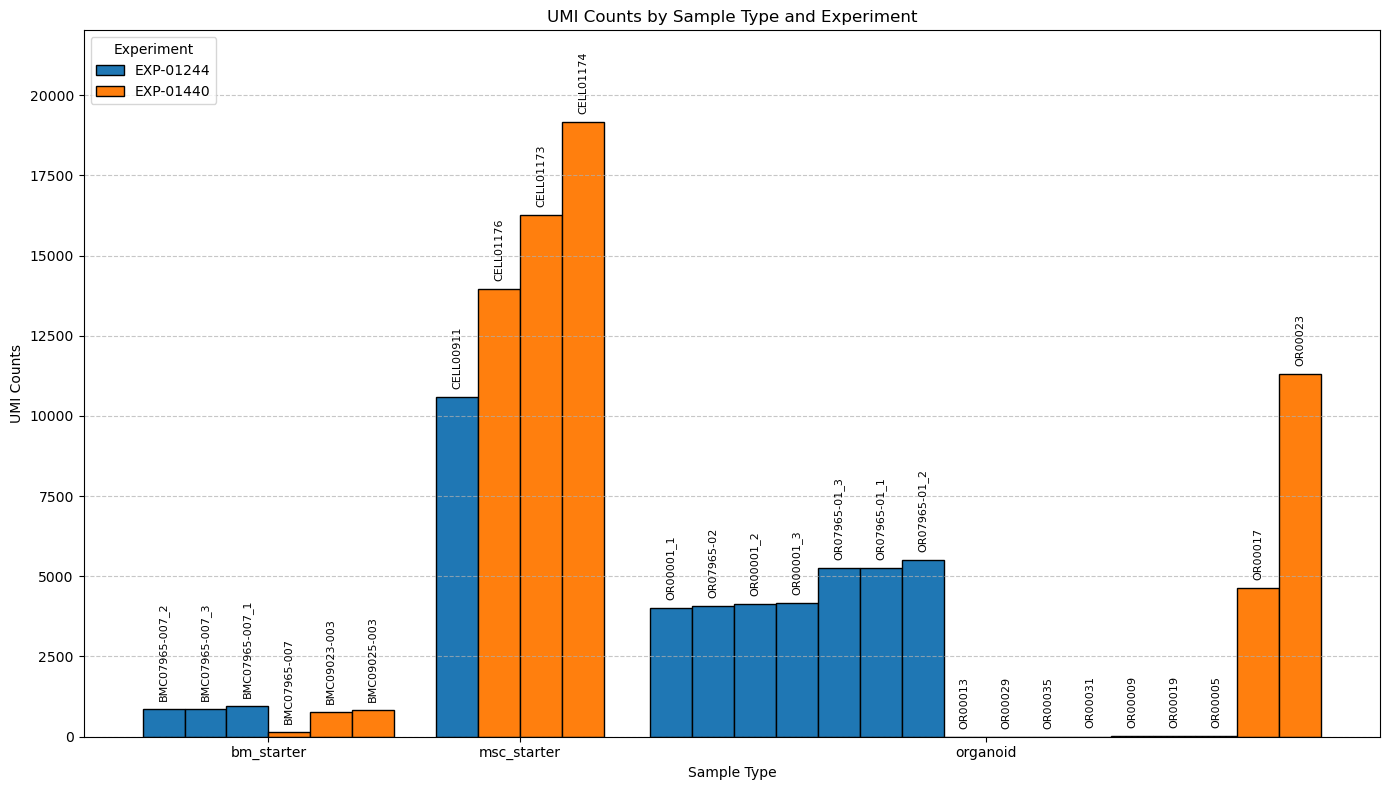

In [116]:
# Group the data by Sample Type
sample_types = sorted(df['Sample Type'].unique())
experiments = sorted(df['EXP #'].unique())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Set width of bars and positions of groups
bar_width = 0.8 / len(df.groupby(['Sample Type', 'EXP #']).size())

group_positions = np.array([0, 0.8, 2.28])

# Create a mapping of experiments to colors
exp_colors = {exp: plt.cm.tab10(i) for i, exp in enumerate(experiments)}

# Create a list to store bar information
bars_info = []

# Process each row of the dataframe
for idx, row in df.iterrows():
    # Get sample information
    sample_type = row['Sample Type']
    sample_name = row['Metric Name']
    experiment = row['EXP #']
    cell_count = row['Median UMI counts per cell']
    
    # Get the actual position value from group_positions, not just the index
    group_idx = sample_types.index(sample_type)
    group_pos = group_positions[group_idx]  # This is the key change
    
    # Store information for plotting later
    bars_info.append({
        'sample_type': sample_type,
        'group_idx': group_idx,
        'group_pos': group_pos,  # Store the actual position
        'sample_name': sample_name,
        'experiment': experiment,
        'cell_count': cell_count
    })
    
# Sort bars within each group based on experiment
bars_info.sort(key=lambda x: (x['group_idx'], x['experiment'], x['cell_count']))

# Calculate positions for each bar
bar_counts = {st: 0 for st in sample_types}
for bar in bars_info:
    sample_type = bar['sample_type']
    # Calculate position within the group
    position_in_group = bar_counts[sample_type]
    total_in_group = sum(1 for b in bars_info if b['sample_type'] == sample_type)
    
    # Calculate x position
    bar['x_pos'] = bar['group_pos'] + (position_in_group - total_in_group/2 + 0.5) * bar_width
    
    # Increment counter
    bar_counts[sample_type] += 1

# Create legend handles
legend_handles = {exp: None for exp in experiments}

# Plot all bars
for bar in bars_info:
    x_pos = bar['x_pos']
    height = bar['cell_count']
    color = exp_colors[bar['experiment']]
    
    # Plot the bar
    bar_obj = ax.bar(x_pos, height, width=bar_width,
                    color=color, edgecolor='black', linewidth=1)
    
    # Update legend handle if needed
    if legend_handles[bar['experiment']] is None:
        legend_handles[bar['experiment']] = bar_obj[0]
    
    # Add sample name annotation
    ax.text(x_pos, height + 250, bar['sample_name'],
            ha='center', va='bottom', rotation=90, fontsize=8)

# Set the x-axis ticks and labels
ax.set_xticks(group_positions)
ax.set_xticklabels(sample_types)

# Add labels and title
plt.xlabel('Sample Type')
plt.ylabel('UMI Counts')
plt.title('UMI Counts by Sample Type and Experiment')

ax.set_ylim(0, max(df['Median UMI counts per cell']) * 1.15)

# Add a legend for the experiments
plt.legend(legend_handles.values(), legend_handles.keys(),
           title='Experiment', loc='upper left')

# Add grid for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [108]:
max(df['Median UMI counts per cell'])

19149